In [1]:
import geopandas as gpd
from shapely.ops import unary_union
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt


In [3]:
# 1) load and project to UTM (metric)
input_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Sibelco_Stuff\DATACUBE\hotosm_fra_buildings_polygons_geojson_clipped.geojson"

gdf = gpd.read_file(input_file)
utm = gdf.estimate_utm_crs()
gdf = gdf.to_crs(utm)

In [7]:
# 2) (REPLACE your binary‐buffer step) build clusters & count buildings
buffer_dist = 100  # meters
# buffer each footprint
buffers = gdf.geometry.buffer(buffer_dist)
# dissolve into multi‐polygons
unioned = unary_union(buffers)
polygons = unioned.geoms if hasattr(unioned, "geoms") else [unioned]
clusters = gpd.GeoDataFrame(geometry=list(polygons), crs=gdf.crs)
clusters["cid"] = clusters.index

# assign each original footprint to a cluster polygon
joined = gpd.sjoin(
    gdf[["geometry"]], clusters[["geometry", "cid"]], how="left", predicate="intersects"
)
# count footprints per cluster
counts = joined.groupby("cid").size()
clusters["count"] = clusters["cid"].map(counts).fillna(0).astype(int)
# ——————————————————————————————————————————


# compute raster parameters (same as before)
resolution = 10  # meters per pixel
minx, miny, maxx, maxy = clusters.total_bounds
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

In [9]:
# 3) rasterize using the counts (fix: use clusters['count'], not clusters.count)
shapes = ((geom, cnt) for geom, cnt in zip(clusters.geometry, clusters["count"]))
mask_cont = rasterize(
    shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint16",
)

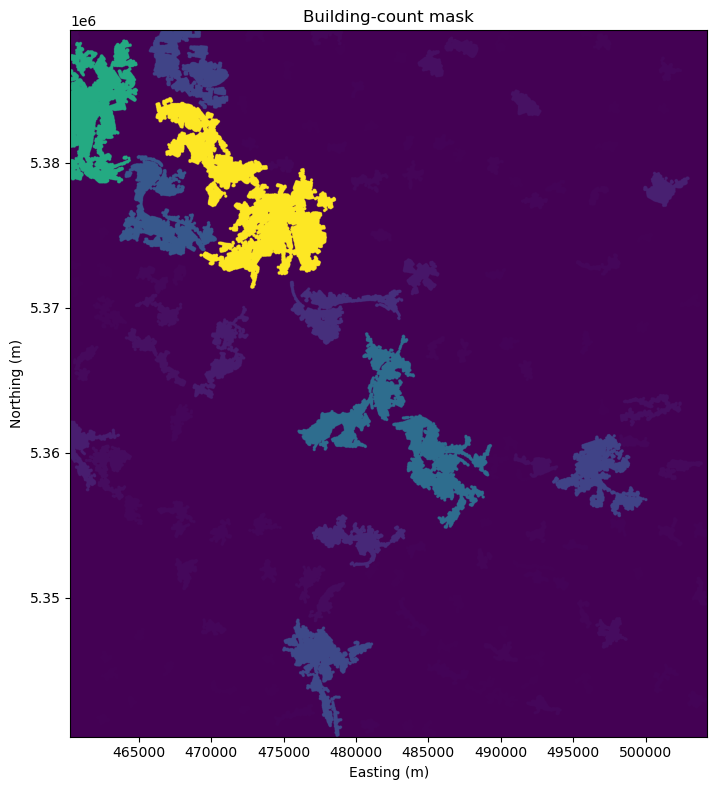

In [10]:
# 4) plot the mask
fig, ax = plt.subplots(figsize=(8, 8))
extent = (minx, maxx, miny, maxy)
ax.imshow(mask_cont, origin="upper", extent=extent)
ax.set_title("Building‐count mask")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()

In [ ]:
# 5) save to GeoTIFF

output_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Sibelco_Stuff\DATACUBE\town_mask_continuous.tif"

with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=mask_cont.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(mask_cont, 1)